In [1]:
import pandas

dataset = pandas.read_table("ICPSR_37692/DS0001/37692-0001-Data.tsv", low_memory=False)
# dataset.drop_duplicates() -- Removed because there are no duplicate values.

In [2]:
def remove_indet(frame, variable_name, keep_dontknow=False, dontknow_signal="-1"):
    ''' 
    Removes entries from the dataframe for which the given variables has a negative, indeterminate value.
    When keep_dontknow is true, it preserves entries for which the value was "-1", which is used in the data as a generic
    "don't know" signal. That operation does not preserve order.
    '''
    neg_mask = frame[f'{variable_name}'].str[0] == "-"
    if keep_dontknow:
        frame1 = frame.query('not @neg_mask')
        frame2 = frame.query(f'{variable_name} == "{dontknow_signal}"')
        frame = pandas.concat([frame1, frame2])
    else:
        frame = frame.query('not @neg_mask')

    return frame
    

First, we will cut the data into sets for specific groups of interest.

In [3]:
'''Select only self-identified transgender people.'''

trans_data = dataset.query('V1212 == "3"')

In [4]:
'''
Select only data on non-straight people. This excludes V1213 answer 2, 
and also people who failed to indicate sexual orientation.

I include people who reported that they did not know their sexual orientation,
either via the -1 "Don't Know" error coding or the 5 "You don't know the answer."
This should allow for questioning people to be included as well.
'''

lgbq_data = dataset.query('V1213 != "2"') 
lgbq_data = remove_indet(lgbq_data, "V1213", keep_dontknow=True)

In [5]:
'''
Select agnc (assigned gender non-conforming) people. I define this to mean people whose assigned sex at birth does not match
their gender, regardless of transgender identification.
'''

agnc_data = dataset.query('V1211 != V1212')
agnc_data = remove_indet(agnc_data, 'V1211')
agnc_data = remove_indet(agnc_data, 'V1212', keep_dontknow=True)

In [6]:
'''
It will be handy to have a set of "non-LGBTQ" people: cis straight people. We'll prefix that cs. 
'''

cis_data = dataset.query('V1211 == V1212')
cs_data = cis_data.query('V1213 == "2"')
cs_data = remove_indet(cs_data, 'V1212')

In [7]:
'''
For a spot of intersectional work, I'll also isolate sets of people who identify with a few distinct racial identities.
Note that, like for the LGBTQ community, I will be using language informed by the data I have, not my political beliefs.
'''



"\nFor a spot of intersectional work, I'll also isolate sets of people who identify with a few distinct racial identities.\nNote that, like for the LGBTQ community, I will be using language informed by the data I have, not my political beliefs.\n"

In [8]:
print(len(dataset))
print(len(trans_data))
print(len(lgbq_data))
print(len(agnc_data))
print(len(cs_data))

24848
31
2139
95
22653


In [9]:
''' Interestingly, only about 1 in 3 ASNC people in this population chose to label themselves transgender. '''
len(trans_data)/len(agnc_data)

0.3263157894736842

In [10]:
''' Merge into a dataset for all lgbtq people. '''
lgbtq_data = pandas.concat([lgbq_data, agnc_data]).drop_duplicates()
len(lgbtq_data)

2169

In [11]:
''' Total LGBTQ rate was 8.7%, markedly higher than the US rate (~3.7%). '''
len(lgbtq_data) / len(dataset)

0.08729072762395364

In [12]:
''' 
71% of LGBTQ respondants identified as female, but only 
25% of the total population did. 
'''

m = len(lgbtq_data.query("V1212 == '1'"))
f = len(lgbtq_data.query("V1212 == '2'"))
print(f / (m+f))

m = len(dataset.query("V1212 == '1'"))
f = len(dataset.query("V1212 == '2'"))
print(f / (m+f))

0.7140672782874617
0.2530443253774963


Seperate these datasets by state.

In [13]:
''' A list of all state codes present in the dataset. Invalid codes are removed. '''
list_state_codes = ['FL', 'MD', 'PA', 'NM', 'KY', 'MA', 'OR', 'WV', 'WI', 'WA', 'MI', 'CA', 'IL', 'VA', 'DE', 'NY', 'NV', 'SD', 'LA', 'UT', 'TX', 'MN', 'MO', 'SC', 'GA', 'NC', 'TN', 'IA', 'OH', 'IN', 'CT', 'MS', 'AR', 'HI', 'OK', 'NJ', 'ID', 'AZ', 'VT', 'NE', 'CO', 'AK', 'AL', 'KS', 'ND', 'RI', 'NH', 'WY', 'MT', 'ME']
# PR, DC removed because other datasets exclude them. Too bad!

In [14]:
''' Read in data needed for the ORR '''

state_lgbt = pandas.read_csv("pop_counts/lbgt_percent_by_state.csv")

state_incs = pandas.read_csv("pop_counts/total_incarcerated_by_state.csv")

In [15]:
''' 
Remove states with too few responses. 
For now I'll say that a state has too few responses when each contributes
more than 1% of the total, i.e. when there are fewer than 100 responses,
or when their response ratio is less than 0.25%
'''

true_list_state_codes = []

print("Removing states with n < 100 or rr < 0.0025:")
for state in list_state_codes:
    N = len(dataset.query(f"V0772 == '{state}'")) 
    I = int(state_incs.query(f'State == "{state}"')['Incarcerated'])
    if N < 100 or (N/I) < 0.0025:
        print(state)
    else:
        true_list_state_codes.append(state)

list_state_codes = true_list_state_codes
print(f"There are {len(list_state_codes)} states left in the sample.")


Removing states with n < 100 or rr < 0.0025:
KY
WA
DE
UT
MN
NJ
ID
VT
CO
ND
RI
NH
WY
MT
ME
There are 35 states left in the sample.


In [16]:
def cut_by_state(frame):
    ''' Divide a dataframe into a dictionary of dataframes by state the inmate was living in at the time of arrest. '''
    statewise_dict = {}
    for state in list_state_codes:
        subset = frame.query(f'V0772 == "{state}"')
        statewise_dict[state] = subset
        
    return statewise_dict
        

In [17]:
lgbtq_bs = cut_by_state(lgbtq_data)

In [18]:
''' Count responses after pruning. '''
s = 0
ls = 0
for state in list_state_codes:
    s += len(dataset.query(f'V0772 == "{state}"'))
    ls += len(lgbtq_bs[state])

print(s)
print(ls)
    

22760
1896


Calculate the LGBTQ overrepresentation index for each state.

The OverRepresentation Ratio is meant to measure how much more likely an LGBTQ person is to be incarcerated in a given
state than a member of the general population. It's made of the following factors:

In [19]:
'''
OverRepresentation Ratio, measures proportion of 
LGBTQ prisoners in sample to ordinary prisoners.

Note that these values are unweighted, and so must be used with care. 

a - number self-reported lgbtq people in sample in state
N - number sampled in state
L - estimated proportion lgbtq in state

o = (a/N) / L

'''
vars_bs = {}

for state in list_state_codes:
    a = len(lgbtq_bs[state])
    L = float(state_lgbt.query(f'State == "{state}"')['Estimated Percent LGBT']) / 100
    I = int(state_incs.query(f'State == "{state}"')['Incarcerated'])
    N = len(dataset.query(f'V0772 == "{state}"'))
    vars_bs[f'{state}'] = [(a/N), L, ((a/N) / L),(N/I)]

In [20]:
rep_plot_frame = pandas.DataFrame.from_dict(vars_bs, orient='index', columns = ['incar', 'general', 'orr', 'rratio'])

<AxesSubplot:>

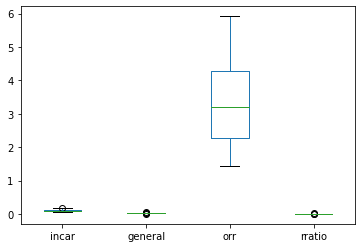

In [21]:
rep_plot_frame.plot.box()

<AxesSubplot:xlabel='general', ylabel='incar'>

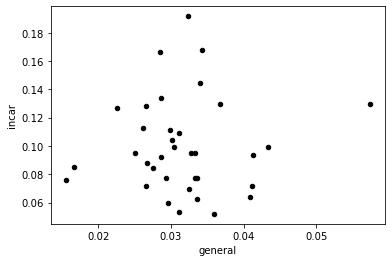

In [62]:
''' There's no obvious pattern except a cluster near the lower area -- a regression may be of use. '''
rep_plot_frame.plot.scatter(x='general', y='incar', c='black')

In [54]:
print(rep_plot_frame.sort_values('orr',axis='index', ascending=False))
print("\nMedians:")
print(rep_plot_frame.median())

       incar   general       orr    rratio
WV  0.191617  0.032366  5.920297  0.008308
NE  0.166667  0.028438  5.860606  0.004378
SD  0.126667  0.022599  5.605000  0.010000
AR  0.085165  0.016567  5.140549  0.005049
AK  0.075949  0.015501  4.899734  0.012248
NM  0.167513  0.034335  4.878807  0.006523
SC  0.128151  0.026607  4.816429  0.006919
OK  0.133721  0.028557  4.682599  0.004617
WI  0.112971  0.026108  4.327076  0.004756
IN  0.144404  0.034017  4.245109  0.003465
KS  0.094972  0.025060  3.789776  0.004649
LA  0.111562  0.029899  3.731303  0.004441
HI  0.129464  0.036723  3.525412  0.008145
CT  0.108844  0.031136  3.495741  0.004933
VA  0.104403  0.030108  3.467626  0.006625
TN  0.088129  0.026651  3.306793  0.004657
NC  0.098985  0.030416  3.254396  0.005278
AL  0.092010  0.028689  3.207195  0.004138
IA  0.084211  0.027575  3.053842  0.004069
MD  0.094808  0.032749  2.895000  0.004475
OH  0.095057  0.033279  2.856354  0.003225
MS  0.072000  0.026546  2.712304  0.007657
MO  0.07743

For comparison, I'll do the same steps to calculate an ORR for the African American community (AAORR).

In [36]:
''' Read in race proportion estimates from each state. '''

state_racial = pandas.read_csv("pop_counts/race_by_state.csv")

In [46]:
aa_data = dataset.query('V1953 == 1')
print(len(aa_data))
aa_bs = cut_by_state(aa_data)

9403


In [47]:
aa_vars_bs = {}

for state in list_state_codes:
    aa = len(aa_bs[state])
    AA = float(state_racial.query(f'Label == "{state}"')['Black or African American'])
    I = int(state_incs.query(f'State == "{state}"')['Incarcerated'])
    N = len(dataset.query(f'V0772 == "{state}"'))
    aa_vars_bs[f'{state}'] = [(aa/N), AA, ((aa/N) / AA), (N/I)]
    
aa_rep_plot_frame = pandas.DataFrame.from_dict(aa_vars_bs, orient='index', columns = ['incar', 'general', 'aaorr', 'rratio'])

<AxesSubplot:>

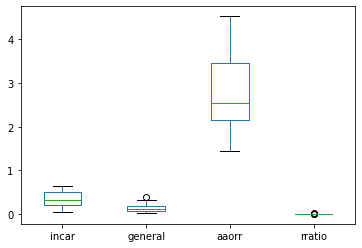

In [65]:
aa_rep_plot_frame.plot.box()

<AxesSubplot:xlabel='general', ylabel='incar'>

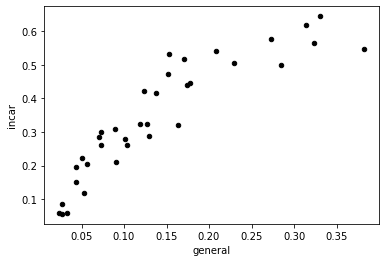

In [61]:
''' There is a clear positive correlation between general AA population and AA prison overrepresentation. '''
aa_rep_plot_frame.plot.scatter(x='general', y='incar', c='black')

In [53]:
print(aa_rep_plot_frame.sort_values('aaorr',axis='index', ascending=False))
print("\nMedians:")
print(aa_rep_plot_frame.median())

       incar  general     aaorr    rratio
IA  0.194737    0.043  4.528764  0.004069
AK  0.221519    0.051  4.343510  0.012248
WI  0.299163    0.073  4.098126  0.004756
CA  0.286377    0.070  4.091097  0.003218
NE  0.205882    0.057  3.611971  0.004378
KS  0.262570    0.073  3.596847  0.004649
MA  0.310345    0.089  3.487021  0.004198
IL  0.532861    0.153  3.482755  0.004843
WV  0.149701    0.043  3.481409  0.008308
PA  0.423193    0.123  3.440592  0.003608
OR  0.084548    0.027  3.131411  0.004183
MI  0.474330    0.152  3.120594  0.015858
NY  0.516402    0.170  3.037660  0.004455
OH  0.417300    0.138  3.023916  0.003225
NV  0.279743    0.101  2.769730  0.007934
CT  0.323129    0.119  2.715372  0.004933
VA  0.542138    0.208  2.606434  0.006625
MO  0.324115    0.127  2.552087  0.008536
FL  0.440000    0.174  2.528736  0.004577
TN  0.446043    0.178  2.505860  0.004657
SD  0.060000    0.024  2.500000  0.010000
IN  0.259928    0.104  2.499306  0.003465
OK  0.209302    0.090  2.325581  0

Now I will attempt to calculate the AORR (AGNC ORR, ORR but for Assigned Gender Non-Conforming indiviuals) and the TORR (Transgender ORR).
The main difference is that the TORR includes only people who answered "transgender" as their gender identity
while the AORR includes those who indicated any other gender than their assigned sex at birth, including "don't know".

In [24]:
''' Read in transgender proportion estimates from each state. '''

state_trans = pandas.read_csv("pop_counts/transgender_by_state.csv")

In [71]:
agnc_bs = cut_by_state(agnc_data)
trans_bs = cut_by_state(trans_data)

at_vars_bs = {}

for state in list_state_codes:
    a = len(agnc_bs[state])
    t = len(trans_bs[state])
    T = float(state_trans.query(f'State == "{state}"')['Proportion']) # This is a falsely named column: it's actually proportion, not percentage. 
    I = int(state_incs.query(f'State == "{state}"')['Incarcerated'])
    N = len(dataset.query(f'V0772 == "{state}"'))
    
    if a > 3:
        at_vars_bs[f'{state}'] = [(a/N), T, ((a/N) / T), ((t/N) / T), (N/I)]
    
agnc_rep_plot_frame = pandas.DataFrame.from_dict(at_vars_bs, orient='index', columns = ['incar', 'general', 'aorr', 'torr', 'rratio'])

In [26]:
print(agnc_rep_plot_frame.sort_values('aorr',axis='index', ascending=False))

       incar  general      aorr      torr    rratio
SC  0.008403   0.0040  2.100840  0.000000  0.006919
OH  0.004753   0.0034  1.397898  0.559159  0.003225
CA  0.007536   0.0055  1.370224  0.737813  0.003218
PA  0.003012   0.0034  0.885897  0.221474  0.003608
GA  0.004355   0.0051  0.854000  0.000000  0.012560
TX  0.002544   0.0042  0.605620  0.259551  0.004036


As we can see, there is not enough data on agnc or trans individuals to do this effectively.

Moving swiftly on, then, I will next check the gender disparity between the LGBTQ and non-LGBTQ prison populations. Evidently, it's quite large, but let's look at it by state. Note: we are *NOT* checking against the general state populations in this step.

In [27]:
cs_bs = cut_by_state(cs_data)

In [28]:
gd_vars_bs = {}

for state in list_state_codes:
    csf = len(cs_bs[state].query("V1212 == '2'")) / len(cs_bs[state])
    qf = len(lgbtq_bs[state].query('V1212 == "2"')) / len(lgbtq_bs[state])
    gd_vars_bs[state] = [csf, qf]
    
gd_plot_frame = pandas.DataFrame.from_dict(gd_vars_bs, orient='index', columns = ['cs_fem_prop', 'lgbtq_fem_prop'])

<AxesSubplot:>

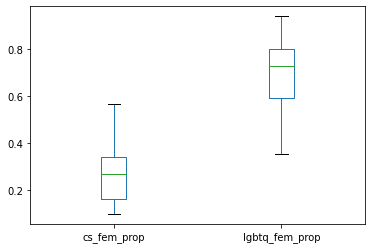

In [29]:
''' Across the board, more of the LGBTQ prison population is female than the cis straight prison population. '''
gd_plot_frame.plot.box()

<AxesSubplot:xlabel='cs_fem_prop', ylabel='lgbtq_fem_prop'>

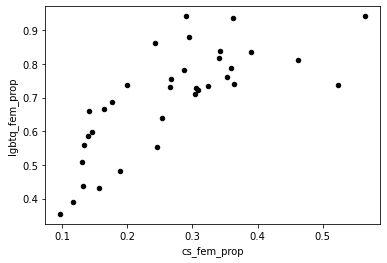

In [30]:
''' Unsurprisingly, prisons with more cis straight females have more lgbtq females also. '''
gd_plot_frame.plot.scatter(x='cs_fem_prop', y='lgbtq_fem_prop', c='black')

In [72]:
'''
Combine the frames so far to allow for more interesting comparisons.
'''

prime_plot_frame = rep_plot_frame.join(gd_plot_frame, how="left").join(aa_rep_plot_frame['aaorr'], how="left").join(agnc_rep_plot_frame['aorr'], how="left")

<AxesSubplot:xlabel='orr', ylabel='lgbtq_fem_prop'>

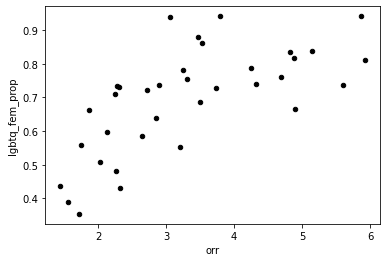

In [73]:
'''
One can observe a positive correlation between the proportion of LGBTQ female inmates (to non-female LGBTQ inmates)
and the ORR.
'''
prime_plot_frame.plot.scatter(x="orr", y="lgbtq_fem_prop", color="black")

<AxesSubplot:xlabel='orr', ylabel='cs_fem_prop'>

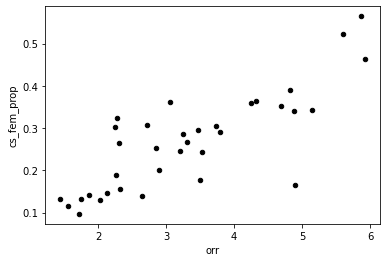

In [74]:
'''
There is another such correlation between the orr and the cis straight female proportion, interestingly.
'''
prime_plot_frame.plot.scatter(x="orr", y="cs_fem_prop", color="black")

<AxesSubplot:xlabel='orr', ylabel='aaorr'>

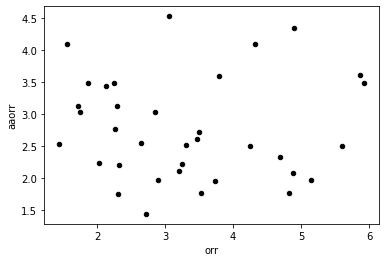

In [78]:
''' There is no clear relation between the aaorr and the orr. Regression? '''
prime_plot_frame.plot.scatter(x="orr", y="aaorr", color="black")

<AxesSubplot:xlabel='orr', ylabel='aorr'>

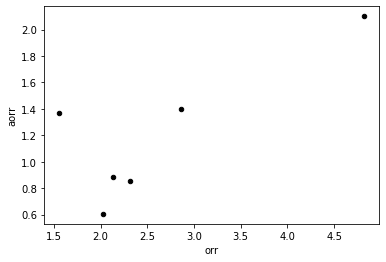

In [77]:
''' Again, hard to say much about the aorr since there is so little data on it. Vague positive correlation? '''
prime_plot_frame.plot.scatter(x="orr", y="aorr", color="black")

TODO LIST

- Find a few more indexes, maybe about treatment or conditions in the prison.
- Start comparing with demographics like you meant to do from the start.